## script for data acquisition

#### Content:
- city boundaries of Graz
- street network of Graz and surrounding area within 1000m
- POIs in Graz and surrounding area withing 1000m: 
  public transport stations, supermarkets, green spaces, pharmacies, doctors
- population of Graz for the year 2020 (100x100m grid)
- buildings of Graz
- residential areas of Graz

#### Data sources:
- City Boundaries:
OpenStreetMap contributors (2025). OpenStreetMap database (city & District Boundaries). Retrieved December 22, 2025, from https://www.openstreetmap.org
- Street Network:
OpenStreetMap contributors (2025). OpenStreetMap database (Street Network). Retrieved December 23, 2025, from https://www.openstreetmap.org
- POIs:
OpenStreetMap contributors. (2025). OpenStreetMap database (POI). Retrieved December 25, 2025, from https://www.openstreetmap.org
- Population 2020 (100m grid):
Pesaresi, M., Schiavina, M., Politis, P., Freire, S., Krasnodębska, K., Uhl, J. H., Carioli, A., Corbane, C., Dijkstra, L., Florio, P., Friedrich, H. K., Gao, J., Leyk, S., Lu, L., Maffenini, L., Mari-Rivero, I., Melchiorri, M., Syrris, V., Van Den Hoek, J., & Kemper, T. (2023). GHS-POP R2023A — GHS population grid multitemporal (1975–2030). Dataset: GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20. European Commission, Joint Research Centre. https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE. Available under: https://human-settlement.emergency.copernicus.eu/download.php?ds=pop
- Buildings:
OpenStreetMap contributors (2025). OpenStreetMap database (Buildings). Retrieved December 26, 2025, from https://www.openstreetmap.org
- Residential Areas:
OpenStreetMap contributors (2025). OpenStreetMap database (Residential). Retrieved December 26, 2025, from https://www.openstreetmap.org

In [ ]:
!pip install osmnx rasterio

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
import numpy as np

Define file and output paths here:

In [2]:
# file path for GHS population grid
# path_pop = r"C:\1_Daten\01_UniGraz\2025 WiSe\VU GIS Analysis Techniques 2\final_project\GIS2_Group3_FinalProject\data\GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"
path_pop = "data/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"
# set output file path for preprocessed population grid for Graz
# path_pop_graz = r"C:\1_Daten\01_UniGraz\2025 WiSe\VU GIS Analysis Techniques 2\final_project\GIS2_Group3_FinalProject\preprocessed\graz_population.tif"
path_pop_graz = "preprocessed/graz_population.tif"

### Data integration

##### Load city boundary of Graz

In [3]:
# define place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change CRS to EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

##### Load district boundaries of Graz

In [4]:
# get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# filter to get only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

##### Load street network of Graz and 1000m beyond

In [ ]:
# buffer (1000m) boundary of Graz
buffered_poly_31256 = gdf_graz.geometry.iloc[0].buffer(1000)

# reproject buffer for osmnx (WGS84)
buffered_poly_wgs84 = (
    gpd.GeoSeries([buffered_poly_31256], crs="EPSG:31256")
    .to_crs("EPSG:4326")
    .iloc[0]
)

try:
    edges = gpd.read_parquet("graz_street_network_edges.parquet")
    nodes = gpd.read_parquet("graz_street_network_nodes.parquet")
except:
    # load street network in buffered polygon, network_type = 'walk'

    # TODO: network type walk or all?
    
    G = ox.graph_from_polygon(
        buffered_poly_wgs84,
        network_type="walk",
        simplify=True
    )

    # reproject to project crs
    G = ox.project_graph(G, to_crs="EPSG:31256")

    # convert street network graphs into two GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # remove list columns
    def drop_list_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        list_cols = [
            c for c in gdf.columns
            if c != "geometry" and gdf[c].apply(lambda x: isinstance(x, list)).any()
        ]
        return gdf.drop(columns=list_cols)

    edges_clean = drop_list_columns(edges)
    nodes_clean = drop_list_columns(nodes)

    # save as GeoParquet
    edges_clean.to_parquet("graz_street_network_edges.parquet", index=False)
    nodes_clean.to_parquet("graz_street_network_nodes.parquet", index=False)
    edges = gpd.read_parquet("graz_street_network_edges.parquet")
    nodes = gpd.read_parquet("graz_street_network_nodes.parquet")


Quick overview map: Plot nodes, edges and boundary of Graz

<Axes: >

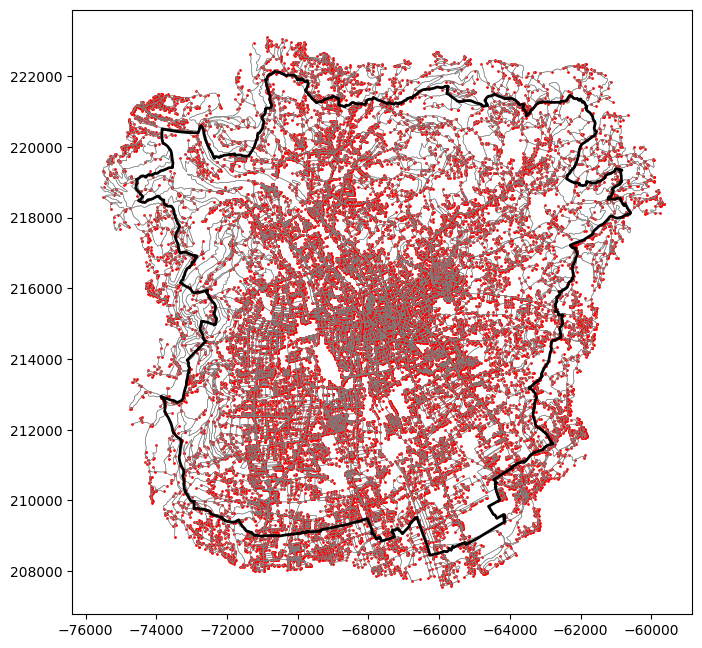

In [6]:
ax = edges.plot(figsize=(8, 8), linewidth=0.4, color="grey")
nodes.plot(ax=ax, markersize=1, color="red")

gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=2)

##### POIs in Graz and surrounding area withing 1000m: public transport stations, supermarkets, green spaces, pharmacies, doctors


Define POI tags (without shop=convenience and leisure=garden)

In [7]:
tags = {
    # public tranport stations & stops
    "highway": ["platform", "bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["platform", "tram_stop", "station", "halt"],

    # supermarkets
    "shop": ["supermarket", "chemist"],

    # pharmacies & doctors
    "amenity": ["doctors", "hospital", "clinic", "pharmacy"],
}

tags_green_spaces = {
    # green spaces
    "leisure": ["park", "garden", "recreation_ground"],
    "landuse": ["forest", "recreation_ground", "cemetery"],
    "natural": ["wood"],
    "amenity": ["park", "playground", "graveyard"],
}

Load POIs from OSM

In [8]:
pois = ox.features_from_polygon(buffered_poly_wgs84, tags=tags) # osmnx sends a request to the Overpass API
pois = pois.to_crs("EPSG:31256")
pois = pois.to_parquet("data/graz_pois.parquet", index=False)
pois = gpd.read_parquet("data/graz_pois.parquet")

Exclude invalid green spaces and calculate access points

In [19]:
# Query raw green spaces once
green_spaces_raw = ox.features_from_polygon(buffered_poly_wgs84, tags=tags_green_spaces)
green_spaces_raw = green_spaces_raw.to_crs("EPSG:31256")

# Save as GeoParquet
green_spaces_raw.to_parquet("data/graz_green_spaces_raw.parquet", index=False)
green_spaces = gpd.read_parquet("data/graz_green_spaces_raw.parquet")


In [20]:
# Drop private gardens without name
green_spaces = green_spaces[~((green_spaces["leisure"] == "garden") & (green_spaces["name"].isna()))]

#exclude public green spaces that are marked as 'no' or 'private' access
green_spaces = green_spaces[green_spaces['access'].isna() | green_spaces['access'].isin(['yes', 'permissive'])]

# Exclude green spaces smaller than 1 ha
green_spaces = green_spaces[green_spaces.geometry.area >= 10000]

# Exclude green spaces within 50m of major roads (highways and trunks)
# Download Highways and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 50 meters around highways
highway_buffer = highways.buffer(50)
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

# Dissolve green spaces
green_spaces = green_spaces.dissolve(as_index=False)

C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\2095571058.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


In [21]:
# Extract boundaries of parks as LineStrings
park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

print(f"Found {len(access_points)} access points")

C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\1210124553.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry


Found 2614 access points


In [22]:
# Save access points as GeoParquet
access_points.to_parquet("data/graz_green_access_points.parquet", index=False)
access_points = gpd.read_parquet("data/graz_green_access_points.parquet")

##### Put together all POIs into one dataset with consistent columns

In [23]:
# initialize columns
pois["poi_group"] = pd.Series(index=pois.index, dtype="string")
pois["poi_subtype"] = pd.Series(index=pois.index, dtype="string")

# TRANSPORT
# Filter for POI group 'transport'
transport_mask = (
    pois["highway"].isin(["platform", "bus_stop"])
    | pois["public_transport"].isin(["platform", "stop_position"])
    | pois["railway"].isin(["platform", "tram_stop", "station", "halt"])
)
pois.loc[transport_mask, "poi_group"] = "transport"

# Fill in tags as subtype
transport_tags = (
    pois.loc[transport_mask, ["highway", "public_transport", "railway"]]
    .astype("string")
    .replace("nan", pd.NA)
    .bfill(axis=1)
    .iloc[:, 0]
)
pois.loc[transport_mask, "poi_subtype"] = transport_tags

# SHOP
shop_mask = pois["shop"].isin(["supermarket", "chemist"])
pois.loc[shop_mask, "poi_group"] = "shop"
pois.loc[shop_mask, "poi_subtype"] = pois.loc[shop_mask, "shop"]

# MEDICAL
medical_values = ["doctors", "hospital", "clinic", "pharmacy"]
med_mask = pois["amenity"].isin(medical_values)
pois.loc[med_mask, "poi_group"] = "medical"
pois.loc[med_mask, "poi_subtype"] = pois.loc[med_mask, "amenity"]


In [24]:
access_points["poi_group"] = "green_space"
access_points["poi_subtype"] = "access_point"

In [25]:
# Save all POIs including green access points into a single GeoParquet

# Make sure both in same CRS
access_points = access_points.to_crs(pois.crs)

# Ensure both have the same columns
all_cols = sorted(set(pois.columns) | set(access_points.columns))

pois_all = pd.concat(
    [
        pois.reindex(columns=all_cols),
        access_points.reindex(columns=all_cols),
    ],
    ignore_index=True,
)

pois_all.to_parquet("data/graz_pois_with_green_access.parquet", index=False)
pois_all = gpd.read_parquet("data/graz_pois_with_green_access.parquet")


In [ ]:
# Drop redudant columns?

Quick overview map: Plot POIs per tag and boundary of Graz

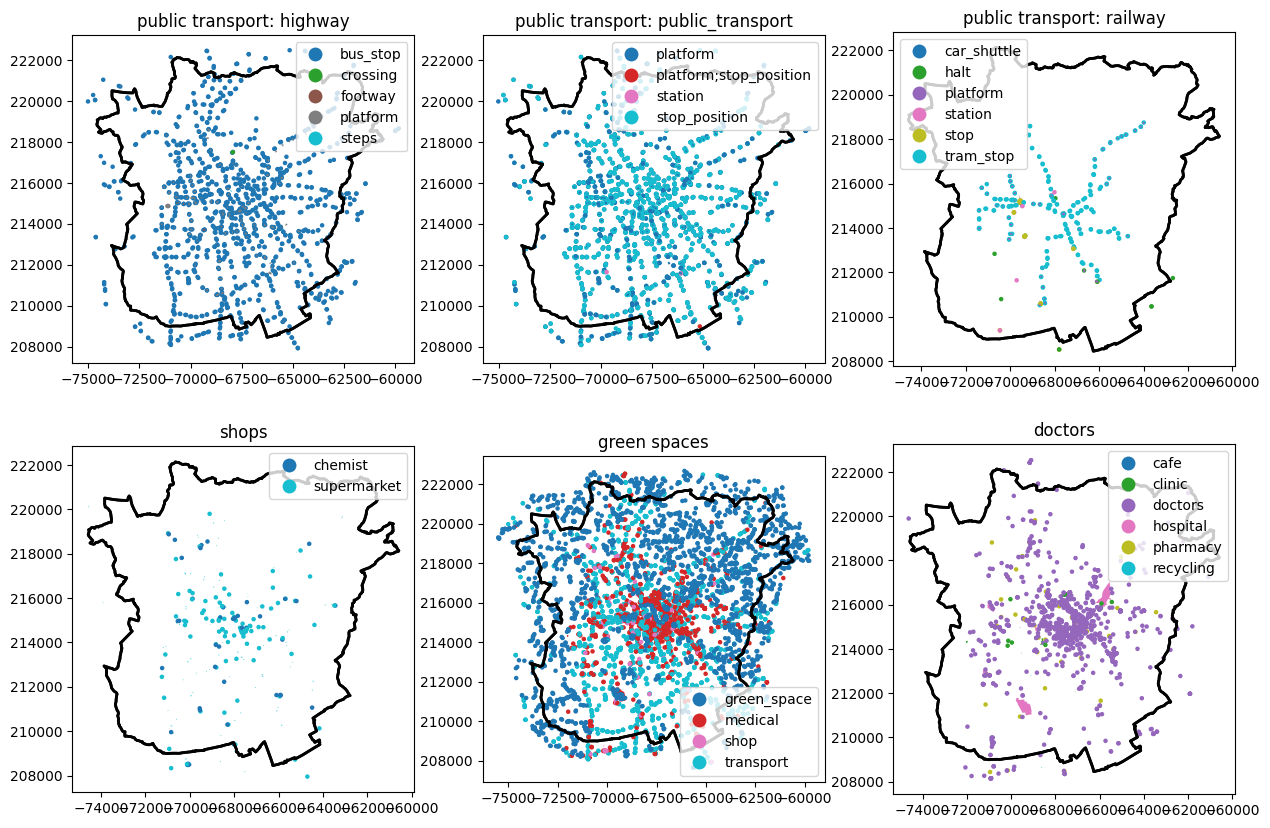

In [ ]:
# Plots with OSM columns

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

ax1_1 = axs[0, 0]
pois_all.plot(ax=ax1_1, column="highway", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_1, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_1, facecolor="none", edgecolor="black", linewidth=2)
ax1_1.set_title("public transport: highway")

ax1_2 = axs[0, 1]
pois_all.plot(ax=ax1_2, column="public_transport", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_2, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_2, facecolor="none", edgecolor="black", linewidth=2)
ax1_2.set_title("public transport: public_transport")

ax1_3 = axs[0, 2]
pois_all.plot(ax=ax1_3, column="railway", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_3, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_3, facecolor="none", edgecolor="black", linewidth=2)
ax1_3.set_title("public transport: railway")

ax2 = axs[1, 0]
pois_all.plot(ax=ax2, column="shop", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax2, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax2, facecolor="none", edgecolor="black", linewidth=2)
ax2.set_title("shops")

ax3 = axs[1, 1]
pois_all.plot(ax=ax3, column="poi_group", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax3, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax3, facecolor="none", edgecolor="black", linewidth=2)
ax3.set_title("green spaces")

ax4 = axs[1, 2]
pois_all.plot(ax=ax4, column="amenity", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax4, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax4, facecolor="none", edgecolor="black", linewidth=2)
ax4.set_title("doctors")

plt.show()

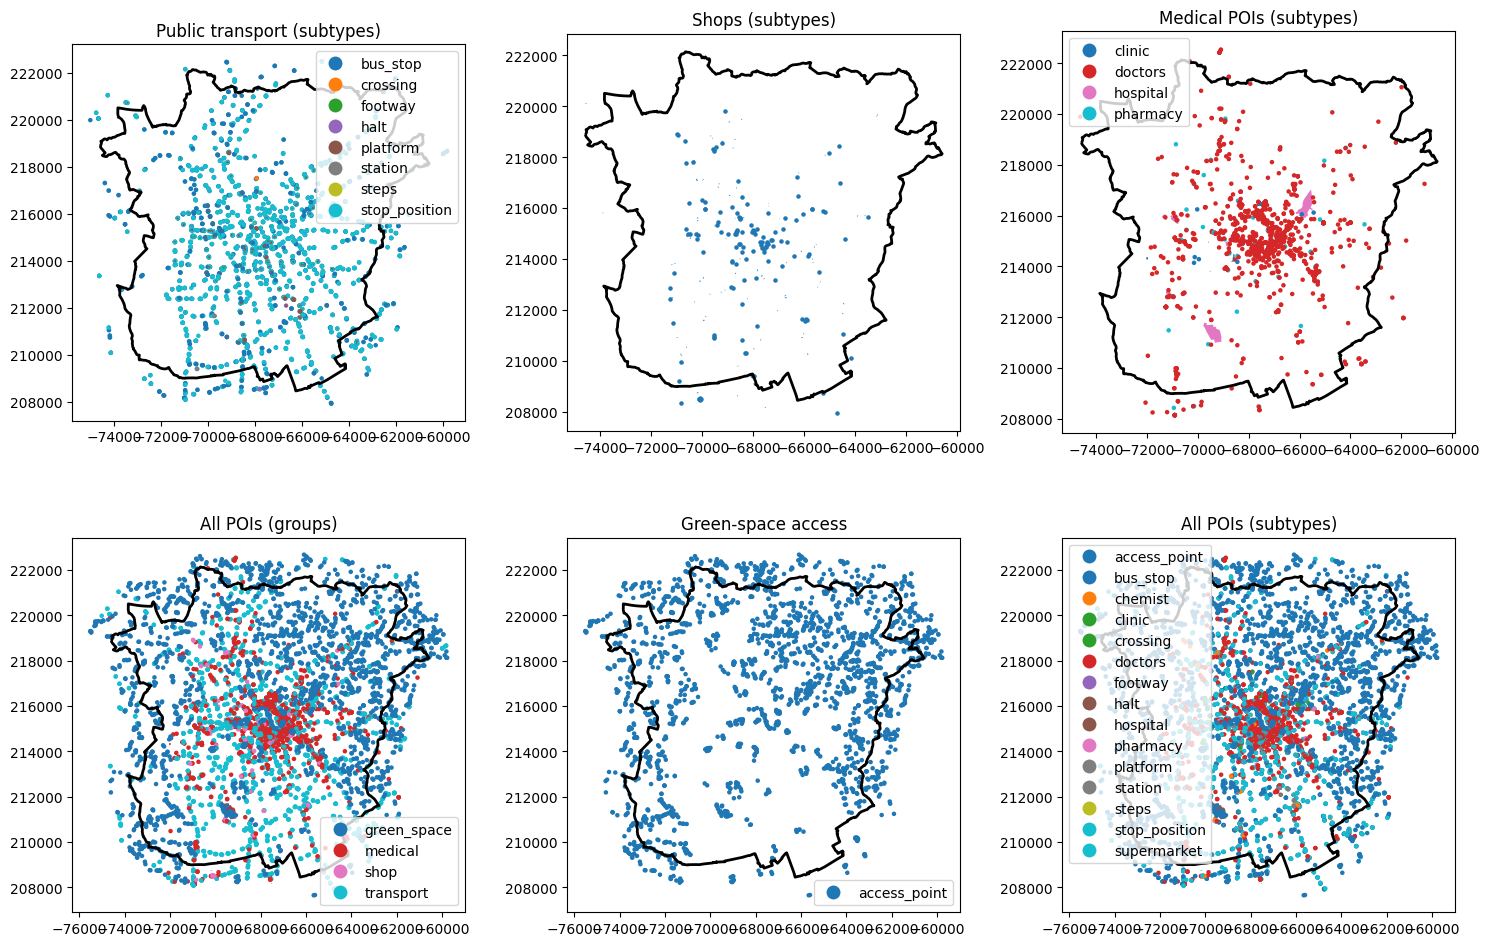

In [ ]:
# Plots with poi_group and poi_subtype

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 1) All public transport POIs by subtype (bus_stop, platform, tram_stop, station, halt)
ax1_1 = axs[0, 0]
mask_pt = pois_all["poi_group"] == "transport"
pois_all[mask_pt].plot(
    ax=ax1_1,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_1, edgecolor="black", linewidth=2)
ax1_1.set_title("Public transport (subtypes)")

# 2) Shops by subtype (supermarket, chemist)
ax1_2 = axs[0, 1]
mask_shop = pois_all["poi_group"] == "shop"
pois_all[mask_shop].plot(
    ax=ax1_2,
    #column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_2, edgecolor="black", linewidth=2)
ax1_2.set_title("Shops (subtypes)")

# 3) Medical POIs (doctors, hospital, clinic, pharmacy)
ax1_3 = axs[0, 2]
mask_med = pois_all["poi_group"] == "medical"
pois_all[mask_med].plot(
    ax=ax1_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_3, edgecolor="black", linewidth=2)
ax1_3.set_title("Medical POIs (subtypes)")

# 4) All POIs by broad group (transport / shop / medical / green_space / other)
ax2_1 = axs[1, 0]
pois_all.plot(
    ax=ax2_1,
    column="poi_group",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_1, edgecolor="black", linewidth=2)
ax2_1.set_title("All POIs (groups)")

# 5) Green-space access points
ax2_2 = axs[1, 1]
mask_green = pois_all["poi_group"] == "green_space"
pois_all[mask_green].plot(
    ax=ax2_2,
    column="poi_subtype",   # e.g. 'access_point'
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_2, edgecolor="black", linewidth=2)
ax2_2.set_title("Green-space access")

# 6) Optional: all POIs again, but colored by subtype
ax2_3 = axs[1, 2]
pois_all.plot(
    ax=ax2_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_3, edgecolor="black", linewidth=2)
ax2_3.set_title("All POIs (subtypes)")

plt.tight_layout()
plt.show()


Quick overview: Display number of features

In [30]:
for col in ["amenity", "shop", "leisure", "highway", "public_transport", "railway"]:
    if col in pois.columns:
        print(f"\nDistribution for {col}:")
        print(pois[col].value_counts())


Distribution for amenity:
amenity
doctors      1053
pharmacy       69
clinic         23
hospital        8
recycling       2
cafe            1
Name: count, dtype: int64

Distribution for shop:
shop
supermarket    183
chemist         45
Name: count, dtype: int64

Distribution for highway:
highway
bus_stop    1399
platform     279
footway       24
steps          2
crossing       1
Name: count, dtype: int64

Distribution for public_transport:
public_transport
platform                  1717
stop_position             1487
station                      8
platform;stop_position       1
Name: count, dtype: int64

Distribution for railway:
railway
tram_stop      226
platform       108
stop            28
halt            11
station          9
car_shuttle      1
Name: count, dtype: int64


In [31]:
# how many of each POI group
print("POI groups:")
print(pois["poi_group"].value_counts(dropna=False))

# how many of each POI subtype
print("\nPOI subtypes:")
print(pois["poi_subtype"].value_counts(dropna=False))


POI groups:
poi_group
transport    3231
medical      1153
shop          227
Name: count, dtype: Int64

POI subtypes:
poi_subtype
stop_position    1455
bus_stop         1399
doctors          1053
platform          336
supermarket       183
pharmacy           69
chemist            44
footway            24
clinic             23
station             9
hospital            8
halt                5
steps               2
crossing            1
Name: count, dtype: Int64


##### Population of Graz (100m grid)

In [32]:
# open grid data set (population grid)
src = rasterio.open(path_pop)
print(src.crs)

# project Graz border into grid CRS (ESRI: 54009)
graz_geom = gdf_graz.to_crs(src.crs).geometry.iloc[0]

# mask grid with Graz geometry (pixels outside Graz are removed)
out_img, out_transform = mask(
    dataset=src,
    shapes=[graz_geom],
    crop=True
)

# copy metadata from the original grid and adjust metadata to the cropped grid
out_meta = src.meta.copy()
out_meta.update({
    "height": out_img.shape[1],
    "width":  out_img.shape[2],
    "transform": out_transform
})

# write and save a new grid
with rasterio.open(path_pop_graz, "w", **out_meta) as dst:
    dst.write(out_img)

ESRI:54009


Load cropped Graz population grid

In [33]:
with rasterio.open(path_pop_graz) as dataset:
    graz_pop = dataset.read(1)

Quick overview of Graz population grid

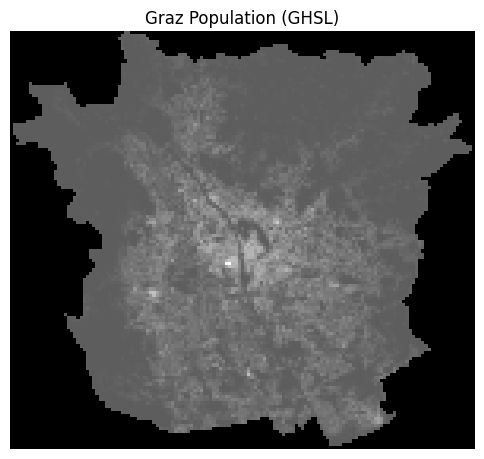

In [34]:
plt.figure(figsize=(6, 6))
plt.imshow(graz_pop, cmap="gray")
plt.title("Graz Population (GHSL)")
plt.axis("off")
plt.show()

##### Buildings of Graz

In [36]:
# load buildings of Graz
gdf_buildings = ox.features_from_place(
    place_name,
    tags={"building": True}
)
gdf_buildings = gdf_buildings.to_crs(epsg=31256)

# Save buildings as GeoParquet
gdf_buildings.to_parquet("data/graz_buildings.parquet", index=False)
gdf_buildings = gpd.read_parquet("data/graz_buildings.parquet")

Quick overview map: Plot buildings of Graz

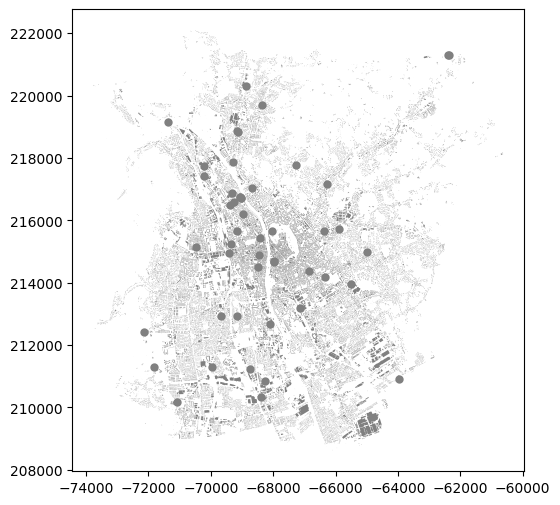

In [ ]:
# all building data of Graz
fig, ax = plt.subplots(figsize=(6, 6))
gdf_buildings.plot(ax=ax, color="grey", linewidth=0)
plt.show()

## TODO: maybe delete point geometries?

##### Residential areas of Graz

In [38]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)

gdf_residential = gdf_residential.dissolve()

gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

# Save residential areas as GeoParquet
gdf_residential.to_parquet("data/graz_residential_areas.parquet", index=False) 
gdf_residential = gpd.read_parquet("data/graz_residential_areas.parquet")

c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 253 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Quick overview map: Plot residential areas of Graz

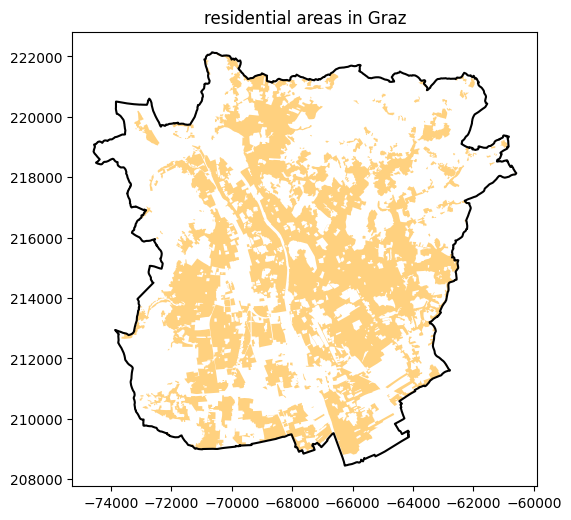

In [39]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(6, 6))

gdf_residential.plot(
    ax=ax,
    color="orange",
    alpha=0.5
)

plt.title("residential areas in Graz")
plt.show()

In [ ]:
# Create buffers around the POIs with walking distance of 15 minutes (1 km at 4 km/h)



# Cut buffers to boundary of Graz

### Buffers: Euclidean Distance

In [40]:
# Create distance buffers, and more metres around the park access points
DISTS:list[int] = [300, 500, 700]  # in meters

In [41]:
graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon

for d in DISTS:
    # Create buffers and clip to city boundary
    pois_all[f'buffer_{d}m'] = pois_all.geometry.buffer(d).intersection(graz_boundary)
    
#create buffer for distances over max DIST and convert Graz boundary to polygon
graz_polygon = gpd.GeoDataFrame(geometry=[graz_boundary], crs=pois_all.crs)
pois_all[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(pois_all[f'buffer_{DISTS[-1]}m'].unary_union)

C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\3936830846.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon
C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\3936830846.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pois_all[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(pois_all[f'buffer_{DISTS[-1]}m'].unary_union)


In [42]:
# Euclidean distance zones for visualization (0–300, 300–500, 500–700, >700 m)

boundary = gdf_graz.unary_union  # city boundary as single polygon

# unions of buffers
buf_300 = pois_all.geometry.buffer(300).unary_union.intersection(boundary)
buf_500 = pois_all.geometry.buffer(500).unary_union.intersection(boundary)
buf_700 = pois_all.geometry.buffer(700).unary_union.intersection(boundary)

rings = []

# 0–300 m
g0_300 = gpd.GeoDataFrame(geometry=[buf_300], crs=pois_all.crs)
g0_300["category"] = "0–300 m"
rings.append(g0_300[["geometry", "category"]])

# 300–500 m
g300_500 = gpd.GeoDataFrame(
    geometry=[buf_500.difference(buf_300)],
    crs=pois_all.crs
)
g300_500["category"] = "300–500 m"
rings.append(g300_500[["geometry", "category"]])

# 500–700 m
g500_700 = gpd.GeoDataFrame(
    geometry=[buf_700.difference(buf_500)],
    crs=pois_all.crs
)
g500_700["category"] = "500–700 m"
rings.append(g500_700[["geometry", "category"]])

# >700 m
city_polygon = gpd.GeoDataFrame(geometry=[boundary], crs=pois_all.crs)
g_over = gpd.GeoDataFrame(
    geometry=city_polygon.geometry.difference(buf_700),
    crs=pois_all.crs
)
g_over["category"] = ">700 m"
rings.append(g_over[["geometry", "category"]])

# merge to one GeoDataFrame
eucl_zones = gpd.GeoDataFrame(
    pd.concat(rings, ignore_index=True),
    crs=pois_all.crs
)


C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\466689434.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf_graz.unary_union  # city boundary as single polygon
C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\466689434.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_300 = pois_all.geometry.buffer(300).unary_union.intersection(boundary)
C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\466689434.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_500 = pois_all.geometry.buffer(500).unary_union.intersection(boundary)
C:\Users\vitad\AppData\Local\Temp\ipykernel_21916\466689434.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_700 = pois_all.geometry.buffer(700).unary_union.intersection(boundary)
